# Deep Convolutional WGANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

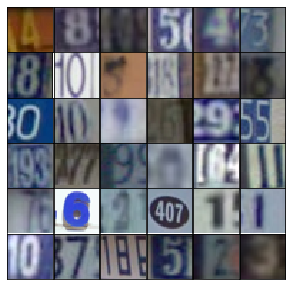

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)): # tanh
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range (-1, 1)
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, output_dim, alpha=alpha)
    Qlogits = discriminator(input_real, alpha=alpha)
    gQlogits = discriminator(input_gen, alpha=alpha, reuse=True)

    #     d_loss_real = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    #     d_loss_fake = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #     g_loss = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    #     d_loss = d_loss_real + d_loss_fake
    
    #d_loss = tf.reduce_mean(tf.square(Qlogits - gQlogits))
    d_loss = tf.reduce_mean(gQlogits) -tf.reduce_mean(Qlogits) 
    g_loss = -tf.reduce_mean(gQlogits)

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                if len(x) != batch_size:
                    print(batch_z.shape, x.shape)
                    
                else:
                    # Run optimizers
                    dloss, _ = sess.run([net.d_loss, net.d_opt], feed_dict={net.input_real: x, net.input_z: batch_z})
                    gloss, _ = sess.run([net.g_loss, net.g_opt], feed_dict={net.input_real: x, net.input_z: batch_z})

                    steps += 1
                    if steps % print_every == 0:
                        # # At the end of each epoch, get the losses and print them out
                        # train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                        # train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(dloss),
                              "Generator Loss: {:.4f}".format(gloss))
                        # Save losses to view after training
                        losses.append((dloss, gloss))

                    if steps % show_every == 0:
                        gen_samples = sess.run(
                                       generator(net.input_z, 3, reuse=True, training=False),
                                       feed_dict={net.input_z: sample_z})
                        samples.append(gen_samples)
                        _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                        plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

Epoch 1/100... Discriminator Loss: -3.1437... Generator Loss: 3.0437
Epoch 1/100... Discriminator Loss: -22.0970... Generator Loss: 20.0453
Epoch 1/100... Discriminator Loss: -43.0031... Generator Loss: 31.6814
Epoch 1/100... Discriminator Loss: -53.5838... Generator Loss: 37.8158
Epoch 1/100... Discriminator Loss: -70.0135... Generator Loss: 44.1562
Epoch 1/100... Discriminator Loss: -72.9560... Generator Loss: 45.6795
Epoch 1/100... Discriminator Loss: -63.6793... Generator Loss: 47.9175
Epoch 1/100... Discriminator Loss: -36.4312... Generator Loss: 35.7297
Epoch 1/100... Discriminator Loss: -53.6312... Generator Loss: 44.3150
Epoch 1/100... Discriminator Loss: -96.8340... Generator Loss: 57.5021


/home/arasdar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


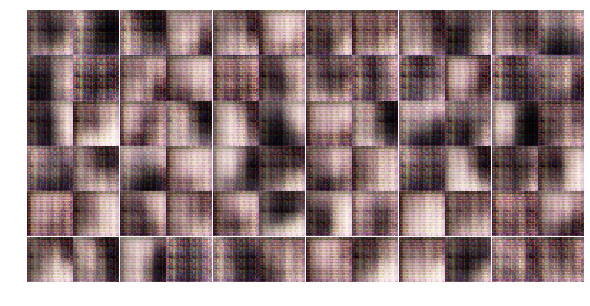

Epoch 1/100... Discriminator Loss: -119.5333... Generator Loss: 65.4662
Epoch 1/100... Discriminator Loss: -134.6616... Generator Loss: 66.3373
Epoch 1/100... Discriminator Loss: -66.4037... Generator Loss: 28.6909
Epoch 1/100... Discriminator Loss: -89.1476... Generator Loss: 43.4811
Epoch 1/100... Discriminator Loss: 7.9286... Generator Loss: 28.1053
Epoch 1/100... Discriminator Loss: -9.7982... Generator Loss: 36.6926
Epoch 1/100... Discriminator Loss: -50.6876... Generator Loss: 9.3624
Epoch 1/100... Discriminator Loss: -40.8816... Generator Loss: 38.2868
Epoch 1/100... Discriminator Loss: -13.6656... Generator Loss: 28.9819
Epoch 1/100... Discriminator Loss: -39.5932... Generator Loss: 24.7148


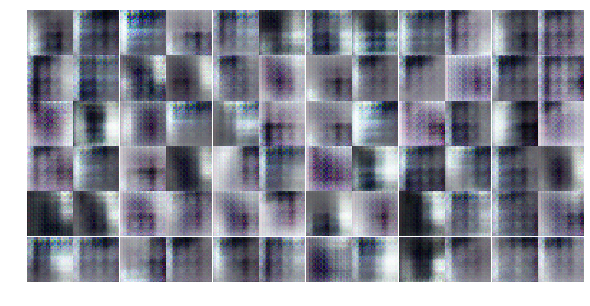

Epoch 1/100... Discriminator Loss: -33.5279... Generator Loss: 30.6462
Epoch 1/100... Discriminator Loss: -24.3937... Generator Loss: 20.1720
Epoch 1/100... Discriminator Loss: -35.1322... Generator Loss: 62.7190
Epoch 1/100... Discriminator Loss: -33.1460... Generator Loss: 69.5869
Epoch 1/100... Discriminator Loss: -8.6039... Generator Loss: 66.4455
Epoch 1/100... Discriminator Loss: -27.8509... Generator Loss: 60.7721
Epoch 1/100... Discriminator Loss: -28.8052... Generator Loss: 67.1062
Epoch 1/100... Discriminator Loss: -59.7629... Generator Loss: 70.1229
Epoch 1/100... Discriminator Loss: -43.3010... Generator Loss: 66.5642
Epoch 1/100... Discriminator Loss: -41.6429... Generator Loss: 59.5476


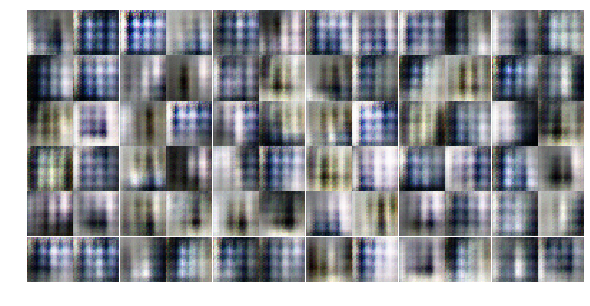

Epoch 1/100... Discriminator Loss: -58.1835... Generator Loss: 65.8623
Epoch 1/100... Discriminator Loss: -59.3313... Generator Loss: 66.7266
Epoch 1/100... Discriminator Loss: -46.3655... Generator Loss: 66.5008
Epoch 1/100... Discriminator Loss: -54.4332... Generator Loss: 64.2122
Epoch 1/100... Discriminator Loss: -112.6637... Generator Loss: 91.0434
Epoch 1/100... Discriminator Loss: -159.6111... Generator Loss: 93.6965
Epoch 1/100... Discriminator Loss: -13.8206... Generator Loss: 30.1115
Epoch 1/100... Discriminator Loss: -35.3445... Generator Loss: 67.9562
Epoch 1/100... Discriminator Loss: -9.1718... Generator Loss: 53.6362
Epoch 1/100... Discriminator Loss: -64.0589... Generator Loss: 77.6701


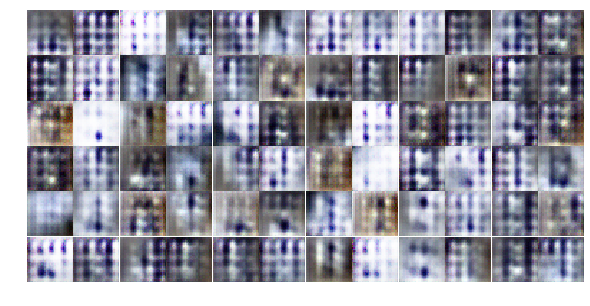

Epoch 1/100... Discriminator Loss: -10.5874... Generator Loss: 49.8827
Epoch 1/100... Discriminator Loss: -84.4098... Generator Loss: 87.3871
Epoch 1/100... Discriminator Loss: -95.4357... Generator Loss: 79.5678
Epoch 1/100... Discriminator Loss: 5.1217... Generator Loss: 79.9147
Epoch 1/100... Discriminator Loss: -4.6544... Generator Loss: 42.5751
Epoch 1/100... Discriminator Loss: -54.0333... Generator Loss: 58.6363
Epoch 1/100... Discriminator Loss: -6.7786... Generator Loss: 43.5608
Epoch 1/100... Discriminator Loss: -19.5553... Generator Loss: 16.5158
Epoch 1/100... Discriminator Loss: -19.8660... Generator Loss: 5.5088
Epoch 1/100... Discriminator Loss: -15.5120... Generator Loss: 12.6365


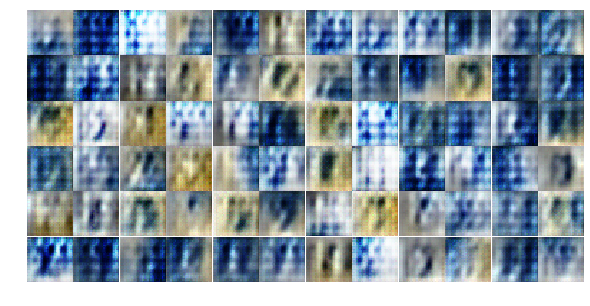

Epoch 1/100... Discriminator Loss: -2.5740... Generator Loss: 7.7256
Epoch 1/100... Discriminator Loss: -44.9103... Generator Loss: 58.0663
Epoch 1/100... Discriminator Loss: -75.6525... Generator Loss: 87.7538
Epoch 1/100... Discriminator Loss: 4.1694... Generator Loss: 49.9044
Epoch 1/100... Discriminator Loss: -30.1168... Generator Loss: 26.7834
Epoch 1/100... Discriminator Loss: -10.1617... Generator Loss: 42.3953
Epoch 1/100... Discriminator Loss: -36.1157... Generator Loss: 40.2743
(128, 100) (41, 32, 32, 3)
Epoch 2/100... Discriminator Loss: -38.0875... Generator Loss: 81.0795
Epoch 2/100... Discriminator Loss: -53.3443... Generator Loss: 94.7174
Epoch 2/100... Discriminator Loss: -14.4921... Generator Loss: 89.7108


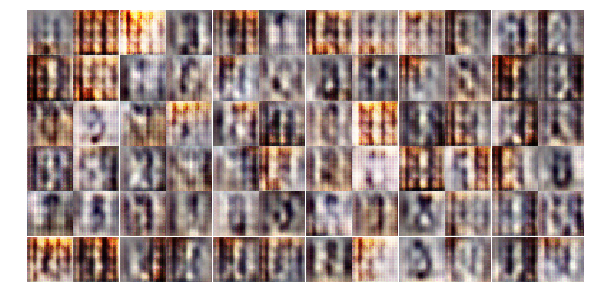

Epoch 2/100... Discriminator Loss: 0.8920... Generator Loss: 81.6096
Epoch 2/100... Discriminator Loss: 1.8678... Generator Loss: 79.4174
Epoch 2/100... Discriminator Loss: -22.5603... Generator Loss: 97.5562
Epoch 2/100... Discriminator Loss: -25.8664... Generator Loss: 69.9394
Epoch 2/100... Discriminator Loss: -15.7931... Generator Loss: 83.4074
Epoch 2/100... Discriminator Loss: 35.4656... Generator Loss: 19.6743
Epoch 2/100... Discriminator Loss: 30.0663... Generator Loss: 48.0369
Epoch 2/100... Discriminator Loss: 2.9985... Generator Loss: 89.9103
Epoch 2/100... Discriminator Loss: -25.4229... Generator Loss: 96.7818
Epoch 2/100... Discriminator Loss: -18.3268... Generator Loss: 90.4584


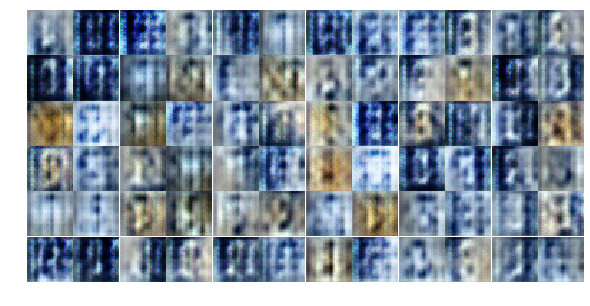

Epoch 2/100... Discriminator Loss: -20.3435... Generator Loss: 56.4000
Epoch 2/100... Discriminator Loss: -19.0632... Generator Loss: 66.9643
Epoch 2/100... Discriminator Loss: -35.6047... Generator Loss: 93.0845
Epoch 2/100... Discriminator Loss: -18.4334... Generator Loss: 65.0734
Epoch 2/100... Discriminator Loss: -55.9425... Generator Loss: 112.7233
Epoch 2/100... Discriminator Loss: -42.8030... Generator Loss: 92.0510
Epoch 2/100... Discriminator Loss: -35.7357... Generator Loss: 69.5616
Epoch 2/100... Discriminator Loss: -53.6863... Generator Loss: 104.6437
Epoch 2/100... Discriminator Loss: -62.4838... Generator Loss: 116.9975
Epoch 2/100... Discriminator Loss: -7.8855... Generator Loss: 115.0510


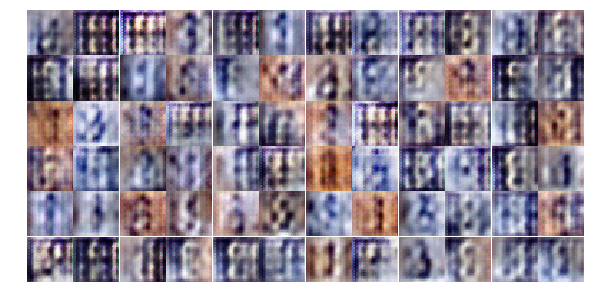

Epoch 2/100... Discriminator Loss: -26.1045... Generator Loss: 104.7664
Epoch 2/100... Discriminator Loss: -23.2490... Generator Loss: 117.8845
Epoch 2/100... Discriminator Loss: -11.0435... Generator Loss: 130.6158
Epoch 2/100... Discriminator Loss: -25.3391... Generator Loss: 129.9859
Epoch 2/100... Discriminator Loss: -41.9510... Generator Loss: 62.5522
Epoch 2/100... Discriminator Loss: -22.3754... Generator Loss: 132.9097
Epoch 2/100... Discriminator Loss: -13.4383... Generator Loss: 39.1876
Epoch 2/100... Discriminator Loss: -12.3901... Generator Loss: 122.9664
Epoch 2/100... Discriminator Loss: 39.8824... Generator Loss: -3.9160
Epoch 2/100... Discriminator Loss: -39.6207... Generator Loss: 62.2231


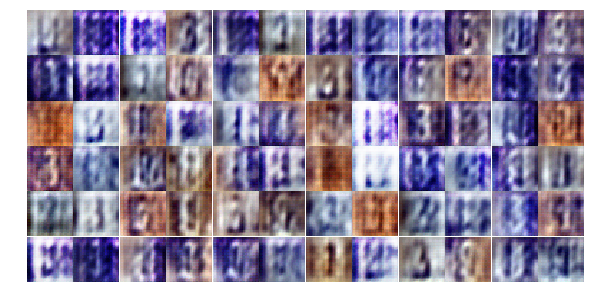

Epoch 2/100... Discriminator Loss: -4.8390... Generator Loss: 59.2242
Epoch 2/100... Discriminator Loss: -3.0870... Generator Loss: -85.3894
Epoch 2/100... Discriminator Loss: -48.8666... Generator Loss: 6.3128
Epoch 2/100... Discriminator Loss: -37.7902... Generator Loss: 95.4246
Epoch 2/100... Discriminator Loss: -24.4781... Generator Loss: 95.3843
Epoch 2/100... Discriminator Loss: -47.2598... Generator Loss: 42.5271
Epoch 2/100... Discriminator Loss: -46.7649... Generator Loss: 62.4031
Epoch 2/100... Discriminator Loss: -22.6668... Generator Loss: 86.6955
Epoch 2/100... Discriminator Loss: -81.5206... Generator Loss: 117.2542
Epoch 2/100... Discriminator Loss: -36.8373... Generator Loss: 71.1449


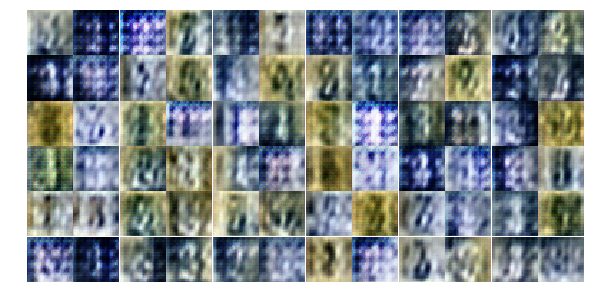

Epoch 2/100... Discriminator Loss: -137.3026... Generator Loss: 123.7459
Epoch 2/100... Discriminator Loss: -63.4274... Generator Loss: 158.5958
Epoch 2/100... Discriminator Loss: -214.0868... Generator Loss: 168.4495
Epoch 2/100... Discriminator Loss: -59.2922... Generator Loss: 177.2316
Epoch 2/100... Discriminator Loss: 22.4277... Generator Loss: 165.9487
Epoch 2/100... Discriminator Loss: -9.2893... Generator Loss: 191.3967
Epoch 2/100... Discriminator Loss: -1.6630... Generator Loss: 130.5744
Epoch 2/100... Discriminator Loss: -14.1150... Generator Loss: 163.0211
Epoch 2/100... Discriminator Loss: -23.8891... Generator Loss: 139.2124
Epoch 2/100... Discriminator Loss: -92.1975... Generator Loss: 132.1044


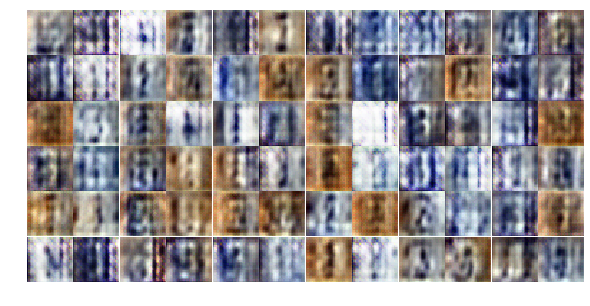

Epoch 2/100... Discriminator Loss: -203.4274... Generator Loss: 115.8984
Epoch 2/100... Discriminator Loss: -250.1127... Generator Loss: 114.3397
Epoch 2/100... Discriminator Loss: 65.6302... Generator Loss: 7.9621
Epoch 2/100... Discriminator Loss: -362.7682... Generator Loss: 199.9134
(128, 100) (41, 32, 32, 3)
Epoch 3/100... Discriminator Loss: -143.3872... Generator Loss: -69.6550
Epoch 3/100... Discriminator Loss: -88.5273... Generator Loss: 60.7169
Epoch 3/100... Discriminator Loss: -504.6577... Generator Loss: 239.3688
Epoch 3/100... Discriminator Loss: -36.6136... Generator Loss: 237.3748
Epoch 3/100... Discriminator Loss: -5.0391... Generator Loss: -267.4633
Epoch 3/100... Discriminator Loss: 4.7471... Generator Loss: -317.4118


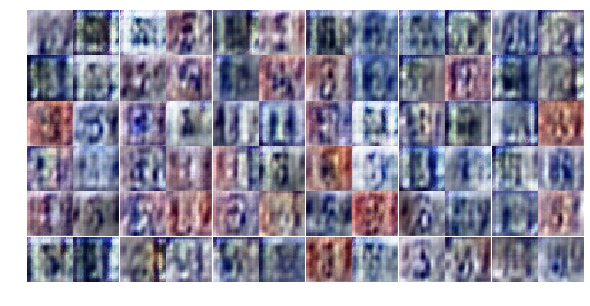

Epoch 3/100... Discriminator Loss: -0.5823... Generator Loss: -314.1563
Epoch 3/100... Discriminator Loss: -9.6184... Generator Loss: -294.2674
Epoch 3/100... Discriminator Loss: -16.9895... Generator Loss: -271.9251
Epoch 3/100... Discriminator Loss: -4.7003... Generator Loss: -263.3459
Epoch 3/100... Discriminator Loss: -14.2908... Generator Loss: -255.7734
Epoch 3/100... Discriminator Loss: -18.0267... Generator Loss: -244.9545
Epoch 3/100... Discriminator Loss: -3.1093... Generator Loss: -240.6369
Epoch 3/100... Discriminator Loss: -17.3218... Generator Loss: -234.8677
Epoch 3/100... Discriminator Loss: -16.4167... Generator Loss: -223.6976
Epoch 3/100... Discriminator Loss: -20.8811... Generator Loss: -216.8957


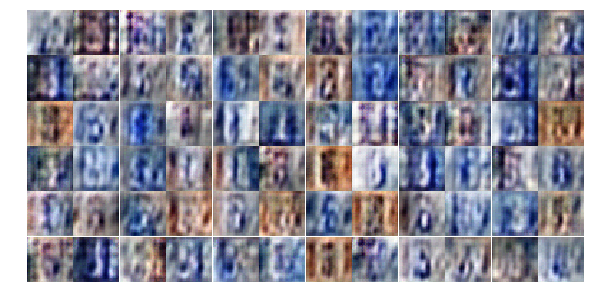

Epoch 3/100... Discriminator Loss: -0.1258... Generator Loss: -194.6586
Epoch 3/100... Discriminator Loss: -115.2702... Generator Loss: 95.8819
Epoch 3/100... Discriminator Loss: -50.1336... Generator Loss: 195.4109
Epoch 3/100... Discriminator Loss: -15.7611... Generator Loss: -230.4198
Epoch 3/100... Discriminator Loss: -23.9483... Generator Loss: -204.6727
Epoch 3/100... Discriminator Loss: -472.2515... Generator Loss: 238.0100
Epoch 3/100... Discriminator Loss: -13.2200... Generator Loss: 217.4377
Epoch 3/100... Discriminator Loss: -45.3378... Generator Loss: 281.7215
Epoch 3/100... Discriminator Loss: -15.9083... Generator Loss: 244.8136
Epoch 3/100... Discriminator Loss: 2.3420... Generator Loss: 250.3676


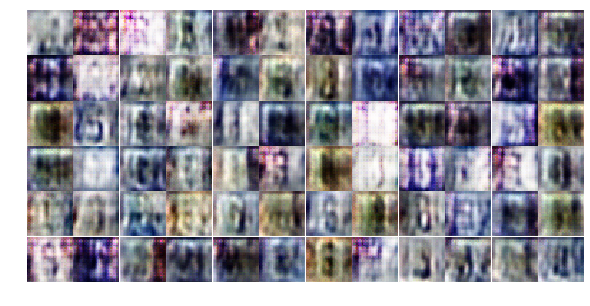

Epoch 3/100... Discriminator Loss: 14.1133... Generator Loss: 285.2570
Epoch 3/100... Discriminator Loss: -25.1822... Generator Loss: 249.7624
Epoch 3/100... Discriminator Loss: -7.2380... Generator Loss: 148.8523
Epoch 3/100... Discriminator Loss: -93.8670... Generator Loss: 135.2378
Epoch 3/100... Discriminator Loss: 19.7850... Generator Loss: 10.4695
Epoch 3/100... Discriminator Loss: -35.2293... Generator Loss: 99.6527
Epoch 3/100... Discriminator Loss: -8.5760... Generator Loss: 30.2549
Epoch 3/100... Discriminator Loss: 13.1805... Generator Loss: 10.9993
Epoch 3/100... Discriminator Loss: 24.3688... Generator Loss: 20.9490
Epoch 3/100... Discriminator Loss: -17.7756... Generator Loss: 9.1630


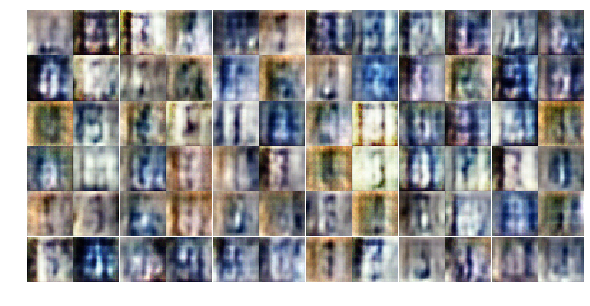

Epoch 3/100... Discriminator Loss: 4.8554... Generator Loss: 26.7022
Epoch 3/100... Discriminator Loss: -21.0778... Generator Loss: 56.9668
Epoch 3/100... Discriminator Loss: 7.2876... Generator Loss: 59.4429
Epoch 3/100... Discriminator Loss: -17.6343... Generator Loss: 68.5766
Epoch 3/100... Discriminator Loss: 2.9342... Generator Loss: 39.9761
Epoch 3/100... Discriminator Loss: 8.5613... Generator Loss: 20.7716
Epoch 3/100... Discriminator Loss: 24.8950... Generator Loss: 6.7005
Epoch 3/100... Discriminator Loss: -15.9457... Generator Loss: 38.1861
Epoch 3/100... Discriminator Loss: -23.6867... Generator Loss: 44.1034
Epoch 3/100... Discriminator Loss: -10.9181... Generator Loss: 47.6145


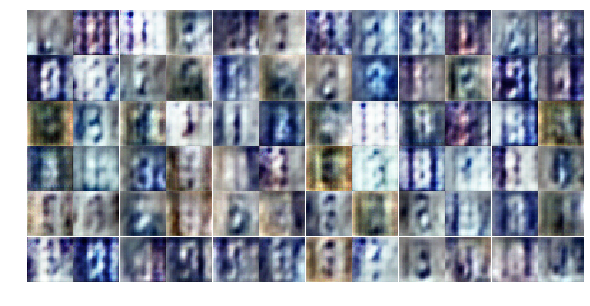

Epoch 3/100... Discriminator Loss: -2.4950... Generator Loss: 39.4269
Epoch 3/100... Discriminator Loss: 1.3663... Generator Loss: 58.1396
Epoch 3/100... Discriminator Loss: -5.0971... Generator Loss: 70.8768
Epoch 3/100... Discriminator Loss: -30.6069... Generator Loss: 51.6500
Epoch 3/100... Discriminator Loss: 2.5760... Generator Loss: 22.7751
Epoch 3/100... Discriminator Loss: -11.2196... Generator Loss: -19.6002
Epoch 3/100... Discriminator Loss: -15.0559... Generator Loss: 29.9515
Epoch 3/100... Discriminator Loss: 7.1247... Generator Loss: -0.2646
Epoch 3/100... Discriminator Loss: -23.4517... Generator Loss: 28.1466
Epoch 3/100... Discriminator Loss: 30.7654... Generator Loss: 16.4595


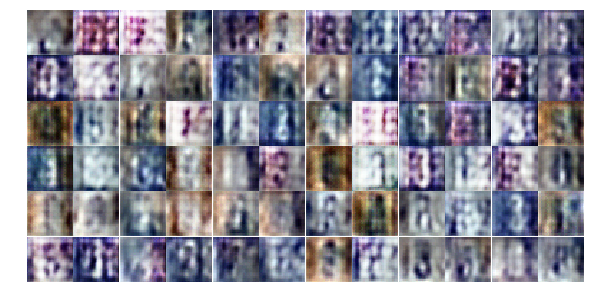

Epoch 3/100... Discriminator Loss: -10.1209... Generator Loss: 52.2785
(128, 100) (41, 32, 32, 3)
Epoch 4/100... Discriminator Loss: -41.9838... Generator Loss: 75.3975
Epoch 4/100... Discriminator Loss: 12.4447... Generator Loss: 54.6656
Epoch 4/100... Discriminator Loss: -11.5642... Generator Loss: 79.7392
Epoch 4/100... Discriminator Loss: 18.3582... Generator Loss: 64.0317
Epoch 4/100... Discriminator Loss: -16.1169... Generator Loss: 58.3103
Epoch 4/100... Discriminator Loss: -13.8369... Generator Loss: 77.5791
Epoch 4/100... Discriminator Loss: -12.4142... Generator Loss: 51.8668
Epoch 4/100... Discriminator Loss: -6.7861... Generator Loss: 44.9800
Epoch 4/100... Discriminator Loss: -4.6688... Generator Loss: 44.2763


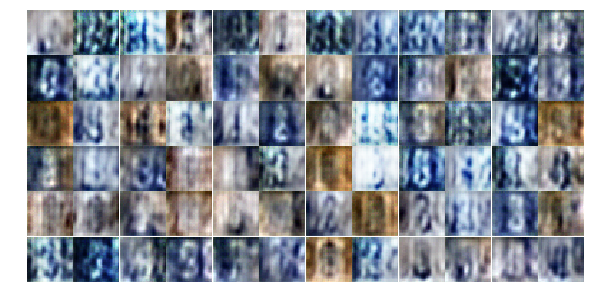

Epoch 4/100... Discriminator Loss: 2.4109... Generator Loss: 63.9763
Epoch 4/100... Discriminator Loss: -18.3876... Generator Loss: 69.5571
Epoch 4/100... Discriminator Loss: -1.6029... Generator Loss: 19.7698
Epoch 4/100... Discriminator Loss: 1.7239... Generator Loss: 23.1713
Epoch 4/100... Discriminator Loss: -3.9010... Generator Loss: 21.8483
Epoch 4/100... Discriminator Loss: -6.8274... Generator Loss: 43.3851
Epoch 4/100... Discriminator Loss: -9.1426... Generator Loss: 46.4613
Epoch 4/100... Discriminator Loss: -9.4678... Generator Loss: 33.7517
Epoch 4/100... Discriminator Loss: -2.3219... Generator Loss: 41.5866
Epoch 4/100... Discriminator Loss: -8.5952... Generator Loss: 31.8655


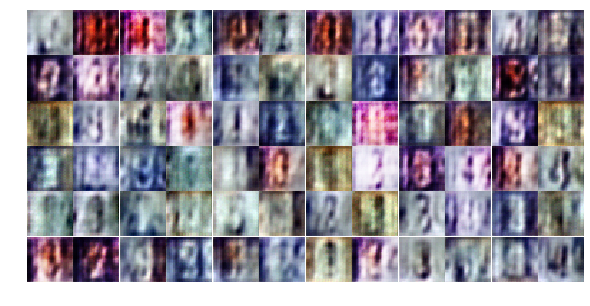

Epoch 4/100... Discriminator Loss: -22.0205... Generator Loss: 43.6643
Epoch 4/100... Discriminator Loss: -3.2120... Generator Loss: 49.6847
Epoch 4/100... Discriminator Loss: -12.9315... Generator Loss: 46.9325
Epoch 4/100... Discriminator Loss: -1.8640... Generator Loss: 55.9514
Epoch 4/100... Discriminator Loss: -10.0006... Generator Loss: 65.8486
Epoch 4/100... Discriminator Loss: -21.6539... Generator Loss: 57.7293
Epoch 4/100... Discriminator Loss: -15.0833... Generator Loss: 60.2587
Epoch 4/100... Discriminator Loss: -12.9971... Generator Loss: 33.6879
Epoch 4/100... Discriminator Loss: 1.0395... Generator Loss: 45.9540
Epoch 4/100... Discriminator Loss: -10.2101... Generator Loss: 51.3088


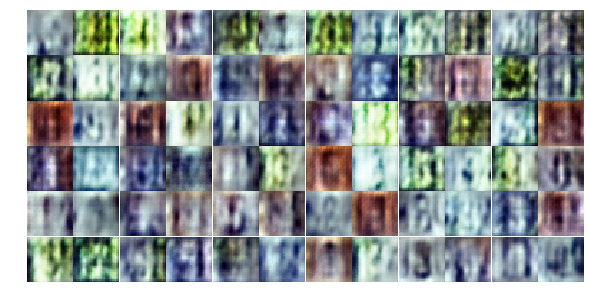

Epoch 4/100... Discriminator Loss: -10.1102... Generator Loss: 60.9379
Epoch 4/100... Discriminator Loss: -10.6790... Generator Loss: 35.9314
Epoch 4/100... Discriminator Loss: -3.3384... Generator Loss: 24.1635
Epoch 4/100... Discriminator Loss: -4.7555... Generator Loss: 19.1937


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

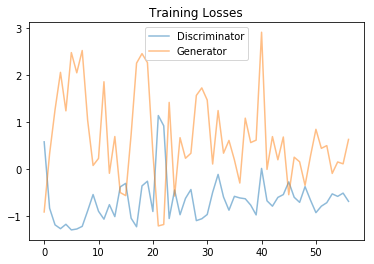

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

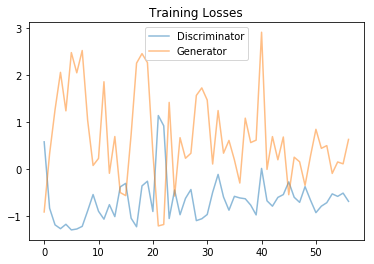

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


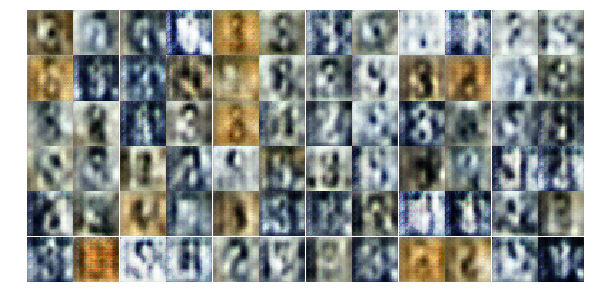

In [24]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

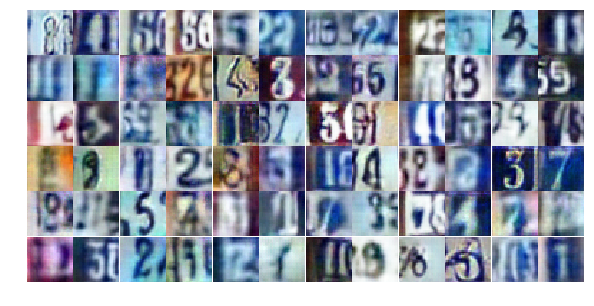

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))